In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import sqlalchemy as sa
import RunData.MyaData as Mya
global beam_stop_atten_time, fcup_offset_time 
from RGA import *
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default="plotly_white"
pio.renderers.default = 'jupyterlab'  # Alternate: 'browser' opens new browser window with plots.

# There were 3 run periods for RGA
run_sub_periods_available = [
        (datetime(2018, 2,  5, 20, 0), datetime(2018,  2,  8, 6, 0)),
        (datetime(2018, 9, 27,  1, 0), datetime(2018, 11, 26, 7, 0)),
        (datetime(2019, 3, 25, 18, 0), datetime(2019,  4, 15, 6, 0))
    ]
data.debug = 1

Imported the RGA info. Setting up data.
setup_rundata_structures(data,(datetime(), datetime()))


## Select the run period
Set the selected_run_period for RGA from 0, 1 or 2.

In [2]:
# Select the run period you want to inspect from 0 to 2.
selected_run_period = 1
print(f"Selected data from run period {selected_run_period} from "
      f"{run_sub_periods_available[selected_run_period][0]:%Y-%m-%d} to {run_sub_periods_available[selected_run_period][1]:%Y-%m-%d}")

Selected data from run period 1 from 2018-09-27 to 2018-11-26


In [3]:
setup_rundata_structures(data, run_sub_periods_available[selected_run_period])

Fetching the data from 2018-09-27 01:00:00 to 2018-11-26 07:00:00
get_runs from 2018-09-27 01:00:00 - 2018-11-26 07:00:00 
Getting data from cache for 2018-09-27 01:00:00 - 2018-11-26 07:00:00 > 500000 evt. 


## Select the run number
For inspecting the run parameters below, choose a run number from the available runs.
You can either select the `i_run`, which is the nth +1 run in the data set and keep `run_number = None`, or you can set `run_number` which is the actual number of the run, but make sure this run_number is actually in the data set.

In [4]:
print("Runs available in this time span:")
print(f"i_run = {0:4d}  --> {data.All_Runs.iloc[0].name}")
print(f"i_run = {len(data.All_Runs)-1:4d}  --> {data.All_Runs.iloc[-1].name}")

Runs available in this time span:
i_run =    0  --> 4862
i_run =  435  --> 5665


In [5]:
# Select the run you want to inspect.
run_number = None
i_run = 325
if run_number is None:
    start_time = data.All_Runs.iloc[i_run].start_time
    end_time = data.All_Runs.iloc[i_run].end_time
    run_number = data.All_Runs.iloc[i_run].name
else:
    i_run = data.All_Runs.index.get_loc(run_number)
    start_time = data.All_Runs.loc[run_number].start_time
    end_time = data.All_Runs.loc[run_number].end_time
           
print(f"Run number = {run_number} index no = {i_run} start_time = {start_time}  end_time = {end_time}")

Run number = 5534 index no = 325 start_time = 2018-11-17 12:58:57  end_time = 2018-11-17 15:31:23


In [6]:
# Initialize the data for the FCUP. We get the entire period because otherwise the beam_stop_atten may be empty.
beam_stop_atten_time, fcup_offset_time =  initialize_fcup_param(run_sub_periods_available[selected_run_period], data=data)
#
# If you want to get *all* the data run with 'override=True", 
# if you also want to get it "fresh" from epicsweb, then run the entire data period with no_cache=True
# Warning: This will take a bit of time!
# beam_stop_atten_time, fcup_offset_time = initialize_fcup_param([datetime(2018, 2,  1, 0, 0),datetime(2019,  4, 15, 6, 0)], override=True, no_cache=True)
#
# Quickly check the sort of this data, since this was an issue before.
print(f"Got {len(fcup_offset_time)} points")
print(f"Is monotonic? ms:{fcup_offset_time['ms'].is_monotonic} index:{fcup_offset_time.index.is_monotonic}")
print(f"Is not double valued? {not np.any(np.roll(fcup_offset_time.index.values, 1) == fcup_offset_time.index.values)}")

Got 81 points
Is monotonic? ms:True index:True
Is not double valued? True


In [7]:
# Uncomment to inspect the FCup data in a table format.
#print("Beam Stop Atten:")
#for inx,item in beam_stop_atten_time.iterrows():
#    print(f"{inx:%Y-%m-%d %H:%M:%S}, {item.value:8.5f}")
#print("FCup Offset")
#for inx,item in fcup_offset_time.iloc[10:16].iterrows():
#    print(f"{inx:%Y-%m-%d %H:%M:%S}, {item.value:8.5f}")

In [8]:
livetime = data.Mya.get(channel="B_DAQ:livetime", start=start_time, end=end_time, run_number=run_number)
livetime_pulser = data.Mya.get(channel="B_DAQ:livetime_pulser", start=start_time, end=end_time, run_number=run_number)
ipm2c21a = data.Mya.get(channel="IPM2C21A", start=start_time, end=end_time, run_number=run_number)
ipm2c24a = data.Mya.get(channel="IPM2C24A", start=start_time, end=end_time, run_number=run_number)
fcup_current = compute_fcup_current(run_number, data=data, current_channel="scalerS2b")

The global variable beam_stop_atten_time and fcup_offset_time must be initialized. Abort.


In [ ]:
# np.isnan(livetime.iloc[0].value)
def plot_trace(in_data, name, color, secondary_y=False):
    if np.all(in_data.value.isnull()):
        print(f"No '{name}' data available.")
    else:
        fig.add_trace(go.Scatter(x=in_data["time"], y=in_data["value"], name=name, line=dict(color=color)), 
                      secondary_y=secondary_y)

No B_DAQ:livetime data available.


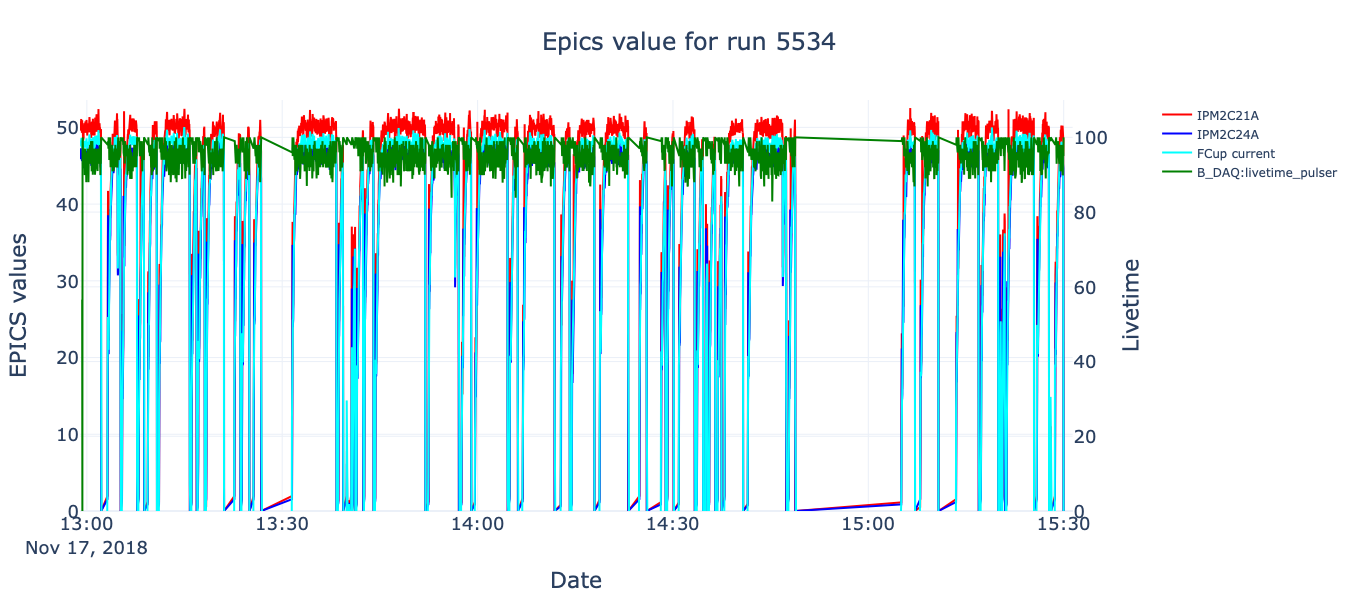

In [30]:
max_y_epics = np.max( [ipm2c21a["value"].max(), ipm2c24a["value"].max()])
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(height=600, width=1200, 
                  title=go.layout.Title(text=f"Epics value for run {data.All_Runs.iloc[i_run].name}", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
plot_trace(ipm2c21a, name="IPM2C21A",color="red")
plot_trace(ipm2c24a,name="IPM2C24A",color="blue")
plot_trace(fcup_current,name="FCup current",color="aqua")
plot_trace(livetime_pulser,"B_DAQ:livetime_pulser",color="green", secondary_y=True)
plot_trace(livetime,"B_DAQ:livetime",color="limegreen", secondary_y=True)
fig.update_xaxes(title_text="Date", titlefont=dict(size=22), tickfont=dict(size=18))
fig.update_yaxes(title_text="EPICS values", titlefont=dict(size=22),range=[0., max_y_epics*1.02], tickfont=dict(size=18))
fig.update_yaxes(title_text="Livetime", titlefont=dict(size=22),range=[0., 110.], tickfont=dict(size=18), secondary_y=True)
fig.show()

## FCup Calculation Values
Inspect the values that go into the FCup current calculation. 

In [31]:
bsat = beam_stop_atten_time.index.get_indexer([start_time], method='nearest')
beam_stop_atten = beam_stop_atten_time.iloc[bsat]

scalerS2b = data.Mya.get(channel="scalerS2b", start=start_time, end=end_time, run_number=run_number)

fcup_offset = fcup_offset_time.loc[start_time:end_time]    # Get the FCup offset values.
fcup_prepend = fcup_offset_time.iloc[fcup_offset_time.index.get_indexer([start_time], method='ffill')] # Get one more before the start_time
fcup_prepend.index=[scalerS2b.iloc[0].time]                                                            # Reset the index of last fcup value to start_time
fcup_offset = pd.concat([fcup_prepend,fcup_offset])                                                    # Add the one value to the list.

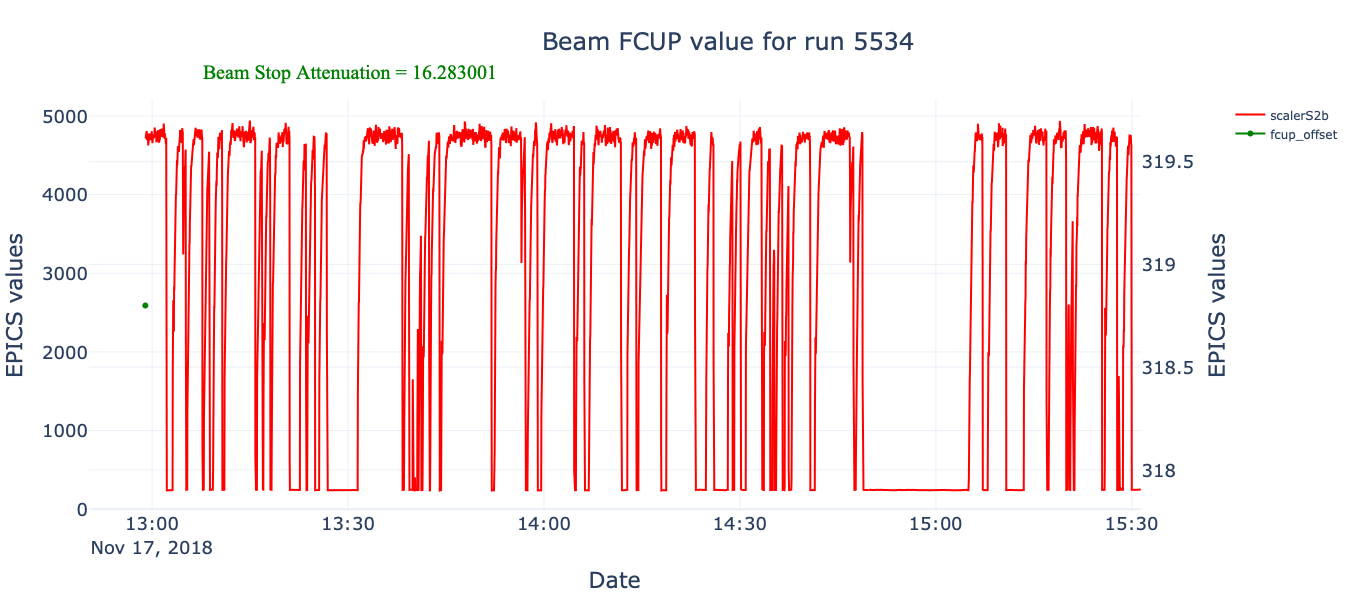

In [32]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(height=600, width=1200, 
                  title=go.layout.Title(text=f"Beam FCUP value for run {data.All_Runs.iloc[i_run].name}", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
fig.add_trace(go.Scatter(x=scalerS2b["time"], y=scalerS2b["value"], name="scalerS2b", line=dict(color="red")))
fig.add_trace(go.Scatter(x=fcup_offset.index, y=fcup_offset["value"], name="fcup_offset", line=dict(color="green"), line_shape='hv'), 
              secondary_y=True)
#fig.add_trace(go.Scatter(x=[scalerS2b.iloc[0].time, scalerS2b.iloc[-1].time], 
#                         y=[beam_stop_atten.value.mean(),beam_stop_atten.value.mean()], name="IPM2C24A", line=dict(color="limegreen")),
#                         secondary_y=True)
fig.update_xaxes(title_text="Date", titlefont=dict(size=22), tickfont=dict(size=18))
fig.update_yaxes(title_text="EPICS values", titlefont=dict(size=22), tickfont=dict(size=18))
#fig.update_yaxes(title_text="Livetime", titlefont=dict(size=22),range=[0., 110.], tickfont=dict(size=18), secondary_y=True)
fig.add_annotation(x=0.1, y=1.1, xref='paper', yref='paper', text=f"Beam Stop Attenuation = {float(beam_stop_atten.value)}", showarrow=False,
                  font=dict(family="Times New Roman", size=20, color="green"))
fig.show()

## Check the FCup Sparsification routines
This checks if we are getting the FCup data correctly. To do so, we need to get the entire set of fcup_offset data, without the sparsification. This will take a bit of time to load, especially if it is not available in the cache, or if you add no_cache=True. In that case, it will fetch 1M data points from epicsweb.

There is no need to run these cells, unless you want to double check the input to the cells in the graph above.

In [ ]:
beam_stop_atten_time, fcup_offset_time = initialize_fcup_param([datetime(2018, 2,  1, 0, 0),datetime(2019,  4, 15, 6, 0)], override=True)

In [121]:
# Test of fcup_offset sparsification
# First: Get an index for the fcup_offset at each time for the scalerS2b where there is beam: value>600, finding the previous fcup_offset value.
fcup_offset_indexes = fcup_offset_time.index.get_indexer(scalerS2b[scalerS2b.value>1000].time.to_list(), method="ffill")
# Make a new dataframe of all these fcup_offset, dropping ones with duplicate values.
fcup_offset_sparse_tmp = fcup_offset_time.iloc[fcup_offset_indexes]
fcup_offset_sparse = pd.concat([fcup_offset_sparse_tmp.iloc[0:1],fcup_offset_sparse_tmp[((fcup_offset_sparse_tmp.shift().value - fcup_offset_sparse_tmp.value).abs() > 0.01)]])

In [122]:
len(scalerS2b), len(fcup_offset_indexes), len(fcup_offset_sparse_tmp), len(fcup_offset_sparse)

(5470, 4134, 4134, 25)

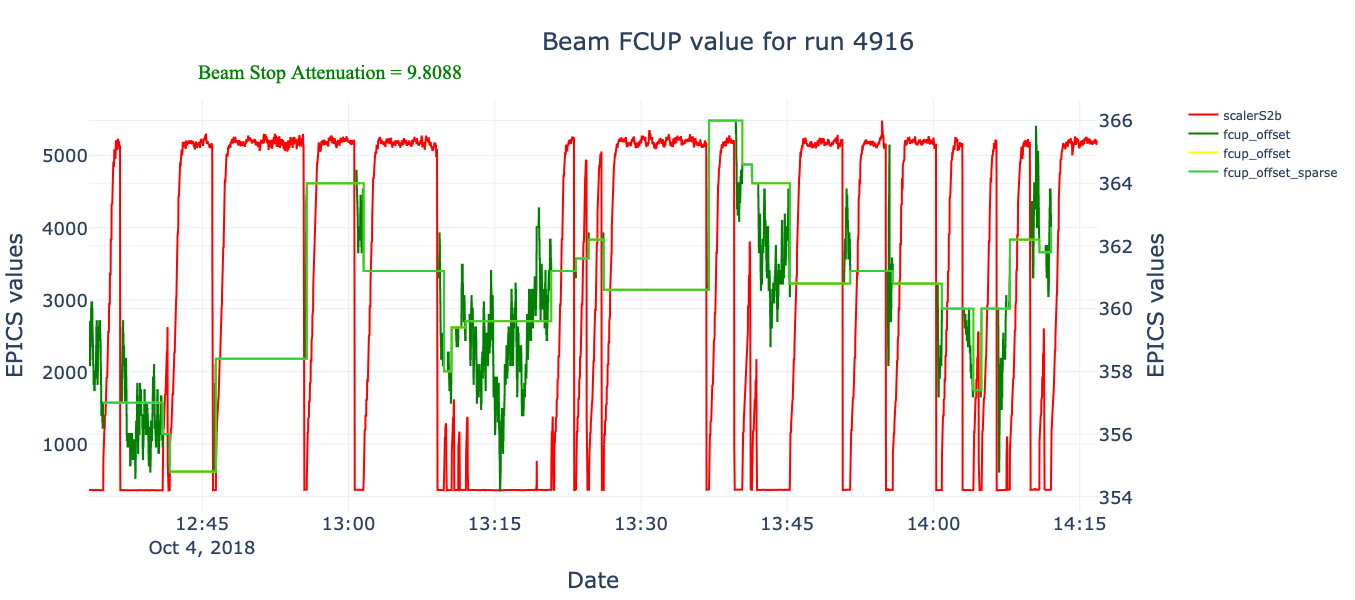

In [123]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(height=600, width=1200, 
                  title=go.layout.Title(text=f"Beam FCUP value for run {data.All_Runs.iloc[i_run].name}", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
fig.add_trace(go.Scatter(x=scalerS2b["time"], y=scalerS2b["value"], name="scalerS2b", line=dict(color="red")))
fig.add_trace(go.Scatter(x=fcup_offset.index, y=fcup_offset["value"], name="fcup_offset", line=dict(color="green"), line_shape='hv'), 
              secondary_y=True)
fig.add_trace(go.Scatter(x=fcup_offset_sparse_tmp.index, y=fcup_offset_sparse_tmp["value"], name="fcup_offset", line=dict(color="yellow"), line_shape='hv'), 
              secondary_y=True)
fig.add_trace(go.Scatter(x=fcup_offset_sparse.index, y=fcup_offset_sparse["value"], name="fcup_offset_sparse", line=dict(color="limegreen"), line_shape='hv'), 
              secondary_y=True)
#fig.add_trace(go.Scatter(x=[scalerS2b.iloc[0].time, scalerS2b.iloc[-1].time], 
#                         y=[beam_stop_atten.value.mean(),beam_stop_atten.value.mean()], name="IPM2C24A", line=dict(color="limegreen")),
#                         secondary_y=True)
fig.update_xaxes(title_text="Date", titlefont=dict(size=22), tickfont=dict(size=18))
fig.update_yaxes(title_text="EPICS values", titlefont=dict(size=22), tickfont=dict(size=18))
#fig.update_yaxes(title_text="Livetime", titlefont=dict(size=22),range=[0., 110.], tickfont=dict(size=18), secondary_y=True)
fig.add_annotation(x=0.1, y=1.1, xref='paper', yref='paper', text=f"Beam Stop Attenuation = {float(beam_stop_atten.value)}", showarrow=False,
                  font=dict(family="Times New Roman", size=20, color="green"))
fig.show()

In [10]:
beam_stop_atten_time

,index,ms,value
time,,,
2018-04-06 18:32:25.826,1,1523039545826,9.808800
2018-05-10 19:46:52.561,4,1525981612561,9.808800
2018-05-10 20:01:17.562,6,1525982477562,9.808800
2018-05-10 20:39:07.828,8,1525984747828,9.808800
2018-05-17 15:55:53.217,10,1526572553217,9.808800
...,...,...,...
2019-12-18 14:23:52.808,158,1576679032808,25.259399
2019-12-19 14:51:29.932,159,1576767089932,12.990000
2019-12-29 16:11:42.696,161,1577635902696,0.000000


In [10]:
'beam_stop_atten_time' in globals(), 'beam_stop_atten_time' in locals()

(True, True)